###Libraries and predefined function

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from typing import Type
from statsmodels.stats.outliers_influence import variance_inflation_factor
!pip install country_converter
from country_converter import CountryConverter
from sklearn.metrics import mean_squared_error


def stepwise_selection_bic_recheck(X, y, initial_list=[], verbose=True):
    """
    Perform a forward-backward feature selection
    based on BIC from statsmodels.api.OLS
    Arguments:
    X - pandas.DataFrame with candidate features
    y - list-like with the target
    initial_list - list of features to start with (column names of X)
    verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features
    """
    included = list(initial_list)
    best_bic = float('inf')
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_bic = {}
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_bic[new_column] = model.bic
        best_new_bic = min(new_bic.values())
        if best_new_bic < best_bic:
            best_bic = best_new_bic
            best_feature = min(new_bic, key=new_bic.get)
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add {:30} with BIC {:.6}'.format(best_feature, best_bic))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        current_bic = model.bic
        bic_diff = {feature: current_bic - sm.OLS(y, sm.add_constant(pd.DataFrame(X[list(set(included) - {feature})]))).fit().bic for feature in included}
        if bic_diff and max(bic_diff.values()) > 0:
            drop = max(bic_diff, key=bic_diff.get)
            included.remove(drop)
            best_bic = current_bic - bic_diff[drop]
            changed = True
            if verbose:
                print('Drop {:30} with BIC {:.6}'.format(drop, best_bic))
        if not changed:
            break
    return included

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-paper', **kwargs):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y

### Data Reading

In [ ]:
df= pd.read_csv("world-data-2023.csv")

columns_to_convert = ['Density\n(P/Km2)', 'Agricultural Land( %)', 'Land Area(Km2)',
                      'Birth Rate', 'Co2-Emissions', 'Forested Area (%)',
                      'CPI', 'CPI Change (%)', 'Fertility Rate', 'Gasoline Price', 'GDP',
                      'Gross primary education enrollment (%)', 'Armed Forces size',
                      'Gross tertiary education enrollment (%)', 'Infant mortality',
                      'Life expectancy', 'Maternal mortality ratio', 'Minimum wage',
                      'Out of pocket health expenditure', 'Physicians per thousand',
                      'Population', 'Population: Labor force participation (%)',
                      'Tax revenue (%)', 'Total tax rate', 'Unemployment rate', 'Urban_population']

# Convert columns using a lambda function
df[columns_to_convert] = df[columns_to_convert].applymap(lambda x: float(str(x).replace(',', '').replace('$', '').replace('%', '')))


#Create a CountryConverter object
cc = CountryConverter()

#Add a 'Continent' column to the dataframe
df['Continent'] = df['Country'].apply(lambda x: cc.convert(names=x, to='continent'))

df = df.dropna(axis=0)

#the new named for our column
column_mapping = {
    'Density\n(P/Km2)': 'Density_P_Km2',
    'Agricultural Land( %)': 'AgriculturalLand_Percentage',
    'Land Area(Km2)': 'LandArea_Km2',
    'Armed Forces size': 'ArmedForcesSize',
    'Birth Rate': 'BirthRate',
    'Calling Code': 'CallingCode',
    'Capital/Major City': 'Capital_MajorCity',
    'Co2-Emissions': 'Co2Emissions',
    'CPI Change (%)': 'CPIChange_Percentage',
    'Currency-Code': 'CurrencyCode',
    'Fertility Rate': 'FertilityRate',
    'Forested Area (%)': 'ForestedArea_Percentage',
    'Gasoline Price': 'GasolinePrice',
    'GDP': 'GDP',
    'Gross primary education enrollment (%)': 'GrossPrimaryEducationEnrollment_Percentage',
    'Gross tertiary education enrollment (%)': 'GrossTertiaryEducationEnrollment_Percentage',
    'Infant mortality': 'InfantMortality',
    'Largest city': 'LargestCity',
    'Life expectancy': 'LifeExpectancy',
    'Maternal mortality ratio': 'MaternalMortalityRatio',
    'Minimum wage': 'MinimumWage',
    'Official language': 'OfficialLanguage',
    'Out of pocket health expenditure': 'OutOfPocketHealthExpenditure',
    'Physicians per thousand': 'PhysiciansPerThousand',
    'Population': 'Population',
    'Population: Labor force participation (%)': 'PopulationLaborForceParticipation_Percentage',
    'Tax revenue (%)': 'TaxRevenue_Percentage',
    'Total tax rate': 'TotalTaxRate',
    'Unemployment rate': 'UnemploymentRate',
    'Urban_population': 'UrbanPopulation',
    'Latitude': 'Latitude',
    'Longitude': 'Longitude',
    'Logged_LE': 'Logged_LE',
    'rec_LE': 'rec_LE',
    'sqrt_LE': 'sqrt_LE',
    'logged_rec_LE': 'logged_rec_LE',
    'squared_LE': 'squared_LE',
    'coxbox_LE': 'coxbox_LE',
    'Continent': 'Continent'
}
#copy for plots
df_plots=df.copy()
# Rename columns using the mapping
df = df.rename(columns=column_mapping)

df = df.select_dtypes(exclude=['object']).drop(['Longitude', 'Latitude'], axis=1)
df = df.drop(['CallingCode'],axis = 1 )

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 110 entries, 0 to 193
Data columns (total 26 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Density_P_Km2                                 110 non-null    float64
 1   AgriculturalLand_Percentage                   110 non-null    float64
 2   LandArea_Km2                                  110 non-null    float64
 3   ArmedForcesSize                               110 non-null    float64
 4   BirthRate                                     110 non-null    float64
 5   Co2Emissions                                  110 non-null    float64
 6   CPI                                           110 non-null    float64
 7   CPIChange_Percentage                          110 non-null    float64
 8   FertilityRate                                 110 non-null    float64
 9   ForestedArea_Percentage                       110 non-null    flo

### Plots

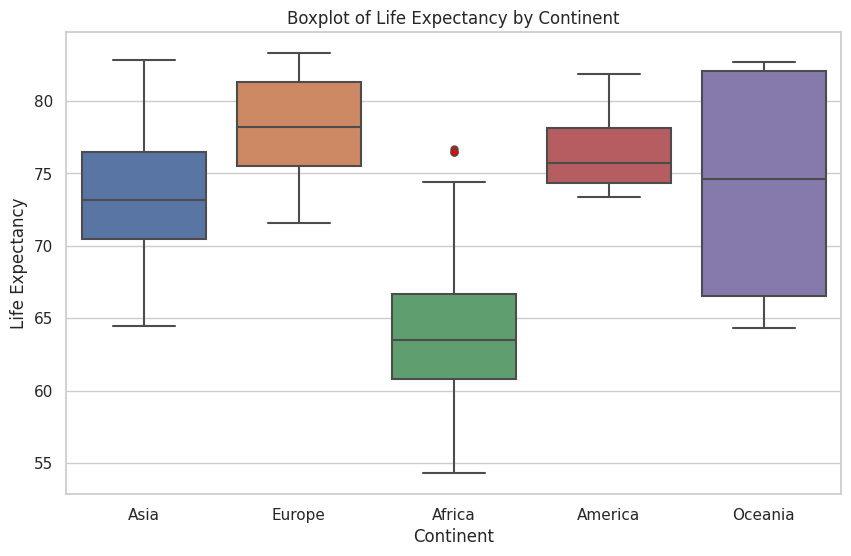

In [ ]:
selected_continents = ['Asia', 'Europe', 'Africa', 'America','Oceania']
filtered_df = df_plots[df_plots['Continent'].isin(selected_continents)]
plt.figure(figsize=(10, 6))
sns.boxplot(x="Continent", y="Life expectancy", data=filtered_df, flierprops=dict(marker="o", markerfacecolor="red", linestyle="none"))
plt.xlabel("Continent")
plt.ylabel("Life Expectancy")
plt.title("Boxplot of Life Expectancy by Continent")
plt.show()

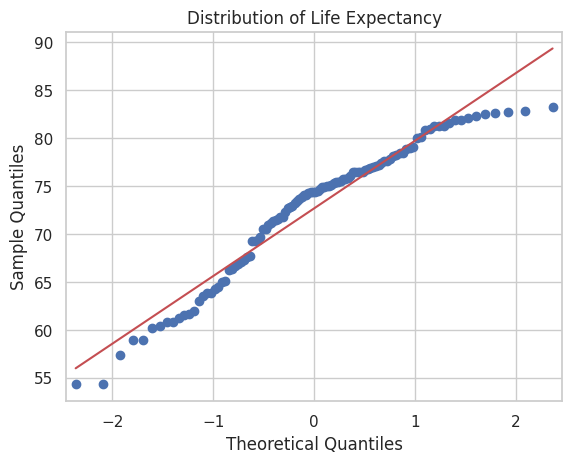

In [ ]:
sm.graphics.qqplot(df_plots['Life expectancy'], line='r')
plt.title('Distribution of Life Expectancy')
plt.show()

In [ ]:
res1=stats.shapiro(df_plots['Life expectancy'])
print('p-value:', round(res1[1],5))

p-value: 0.00018


In [ ]:
df_plots['Life expectancy'].max()

83.3

In [ ]:
df_plots['Life expectancy Negative'] = df_plots['Life expectancy']*(-1)
df_plots['Life expectancy Negative']

0     -64.5
1     -78.5
2     -76.7
4     -60.8
6     -76.5
       ... 
185   -81.3
186   -78.5
187   -77.8
191   -75.3
193   -63.5
Name: Life expectancy Negative, Length: 110, dtype: float64

In [ ]:
df_plots['Life expectancy Negative Shifted'] = df_plots['Life expectancy Negative'] + 91
df_plots['Life expectancy Negative Shifted'].min()

7.700000000000003

In [ ]:
df_plots['Life expectancy Negative l'] = np.log(df_plots['Life expectancy Negative Shifted'])

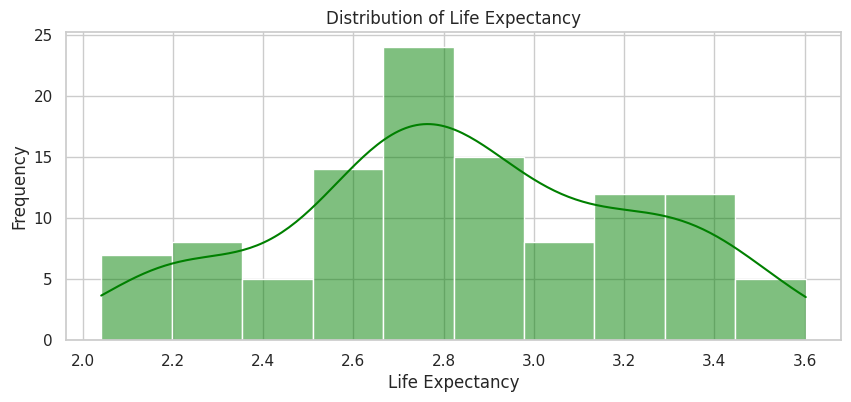

In [ ]:
plt.figure(figsize=(10, 4))
#plt.hist(df['Birth Rate'], bins=20, color='lightblue', kde=True, edgecolor='black')
sns.histplot(data=df_plots, x='Life expectancy Negative l', bins=10, kde=True, color='green')
plt.title('Distribution of Life Expectancy')
plt.xlabel('Life Expectancy')
plt.ylabel('Frequency')
plt.show()

In [ ]:
res1=stats.shapiro(df_plots['Life expectancy Negative l'])
print('p-value:', round(res1[1],5))

p-value: 0.062


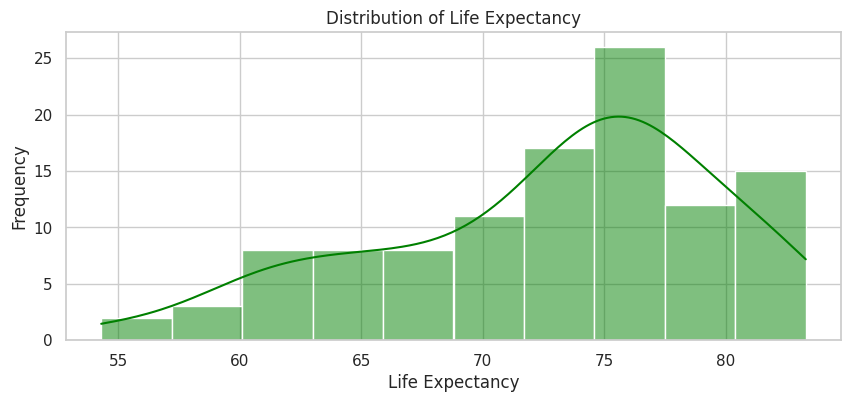

In [ ]:
plt.figure(figsize=(10, 4))
#plt.hist(df['Birth Rate'], bins=20, color='lightblue', kde=True, edgecolor='black')
sns.histplot(data=df_plots, x='Life expectancy', bins=10, kde=True, color='green')
plt.title('Distribution of Life Expectancy')
plt.xlabel('Life Expectancy')
plt.ylabel('Frequency')
plt.show()

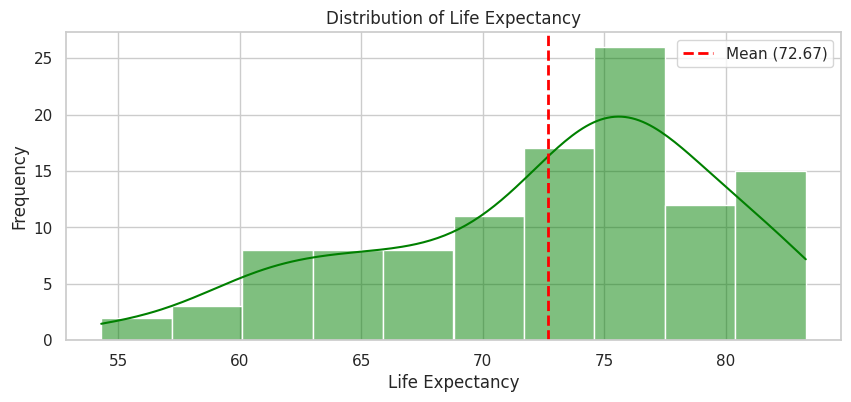

In [ ]:
plt.figure(figsize=(10, 4))
sns.histplot(data=df_plots, x='Life expectancy', bins=10, kde=True, color='green')
plt.title('Distribution of Life Expectancy')
plt.xlabel('Life Expectancy')
plt.ylabel('Frequency')
mean_life_expectancy = df_plots['Life expectancy'].mean()
plt.axvline(mean_life_expectancy, color='red', linestyle='dashed', linewidth=2, label=f'Mean ({mean_life_expectancy:.2f})')
plt.legend()
plt.show()

In [ ]:
top_10_highest_life_expectancy = df_plots.sort_values(by='Life expectancy', ascending=False).head(10)
bottom_10_lowest_life_expectancy = df_plots.sort_values(by='Life expectancy').head(10)

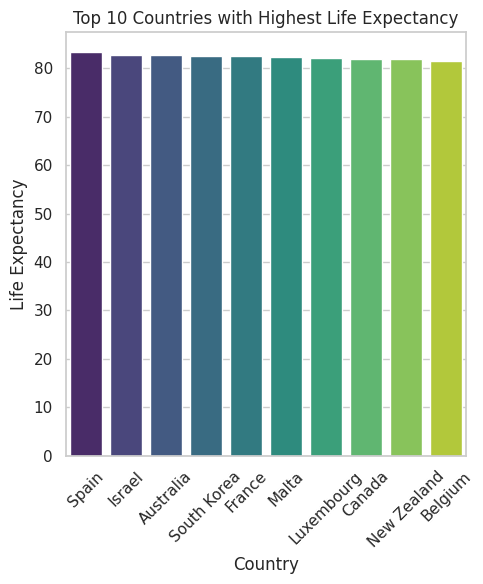

In [ ]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(5, 6))
sns.barplot(data=top_10_highest_life_expectancy, x='Country', y='Life expectancy', palette='viridis')
ax.set_title('Top 10 Countries with Highest Life Expectancy')
ax.set_xlabel('Country')
ax.set_ylabel('Life Expectancy')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

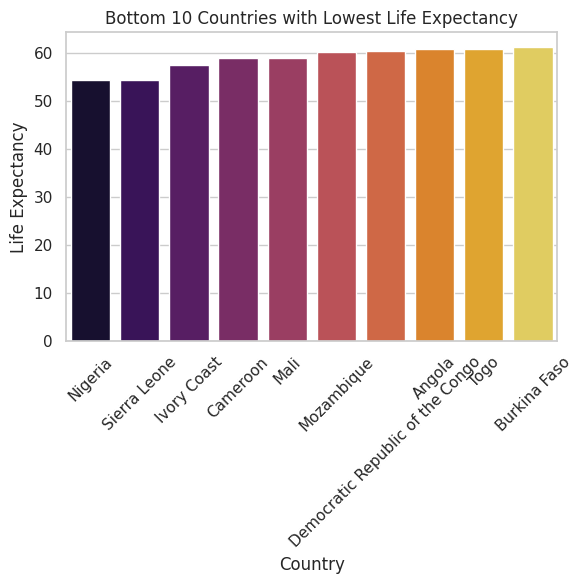

In [ ]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot(data=bottom_10_lowest_life_expectancy, x='Country', y='Life expectancy', palette='inferno')
ax.set_title('Bottom 10 Countries with Lowest Life Expectancy')
ax.set_xlabel('Country')
ax.set_ylabel('Life Expectancy')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

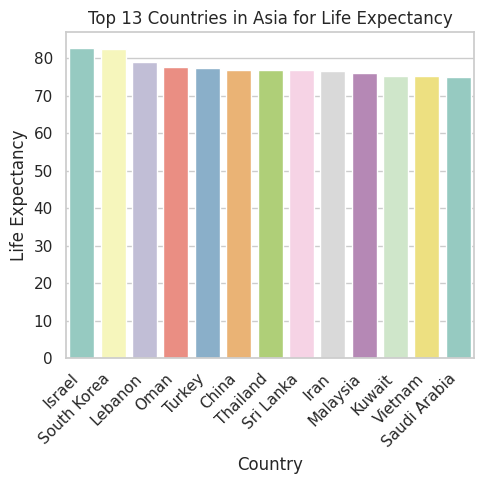

In [ ]:
asia_df = df_plots[df_plots['Continent'] == 'Asia']
asia_df_sorted = asia_df.sort_values(by='Life expectancy', ascending=False)
top_12_asia_life_expectancy = asia_df_sorted.head(13)
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=top_12_asia_life_expectancy, x='Country', y='Life expectancy', palette='Set3')
ax.set_title('Top 13 Countries in Asia for Life Expectancy')
ax.set_xlabel('Country')
ax.set_ylabel('Life Expectancy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

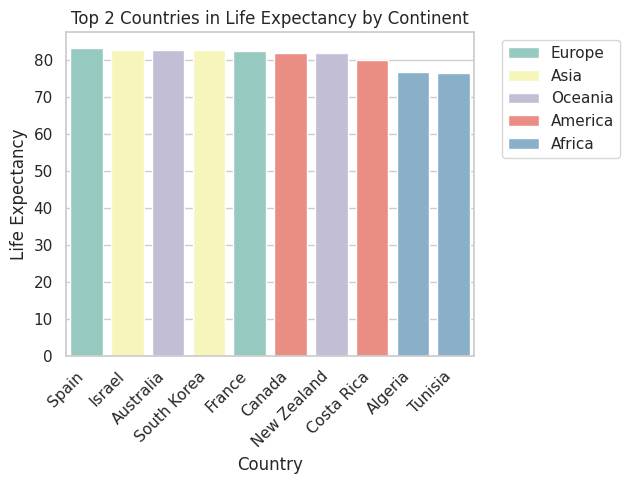

In [ ]:
df_sorted = df_plots.sort_values(by='Life expectancy', ascending=False)
fig, ax = plt.subplots(figsize=(5, 5))
top_5_by_continent = df_sorted.groupby('Continent').head(2)
sns.barplot(data=top_5_by_continent, x='Country', y='Life expectancy', hue='Continent', dodge=False, palette='Set3')
ax.set_title('Top 2 Countries in Life Expectancy by Continent')
ax.set_xlabel('Country')
ax.set_ylabel('Life Expectancy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

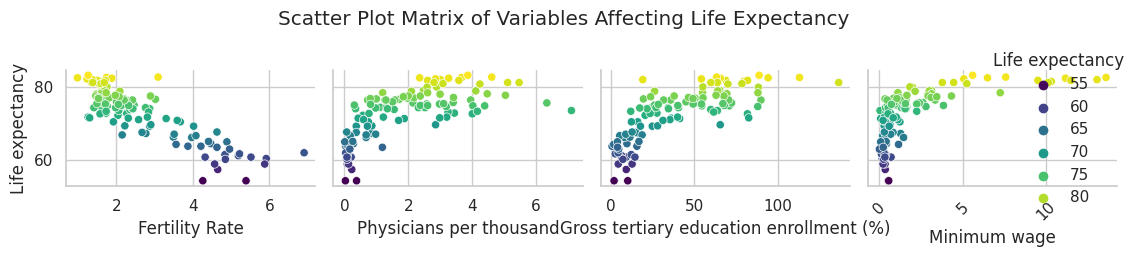

In [ ]:
health_indicators = df_plots[['Life expectancy', 'Fertility Rate', 'Physicians per thousand', 'Gross tertiary education enrollment (%)', 'Minimum wage']]
pair_plot = sns.pairplot(health_indicators, hue='Life expectancy',
                         x_vars=['Fertility Rate', 'Physicians per thousand', 'Gross tertiary education enrollment (%)', 'Minimum wage'],
                         y_vars=['Life expectancy'], palette='viridis')
plt.xticks(rotation=45)
plt.suptitle('Scatter Plot Matrix of Variables Affecting Life Expectancy', y=1.02)
plt.tight_layout()
plt.show()

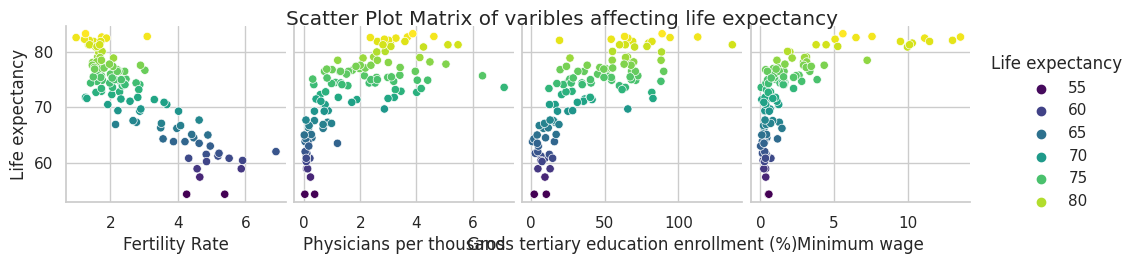

In [ ]:
health_indicators = df_plots[['Life expectancy', 'Fertility Rate', 'Physicians per thousand', 'Gross tertiary education enrollment (%)', 'Minimum wage']]
sns.pairplot(health_indicators, hue='Life expectancy',
             x_vars=['Fertility Rate', 'Physicians per thousand', 'Gross tertiary education enrollment (%)', 'Minimum wage'],
             y_vars=['Life expectancy'], palette='viridis')
plt.suptitle('Scatter Plot Matrix of varibles affecting life expectancy', y=1.02)
plt.show()

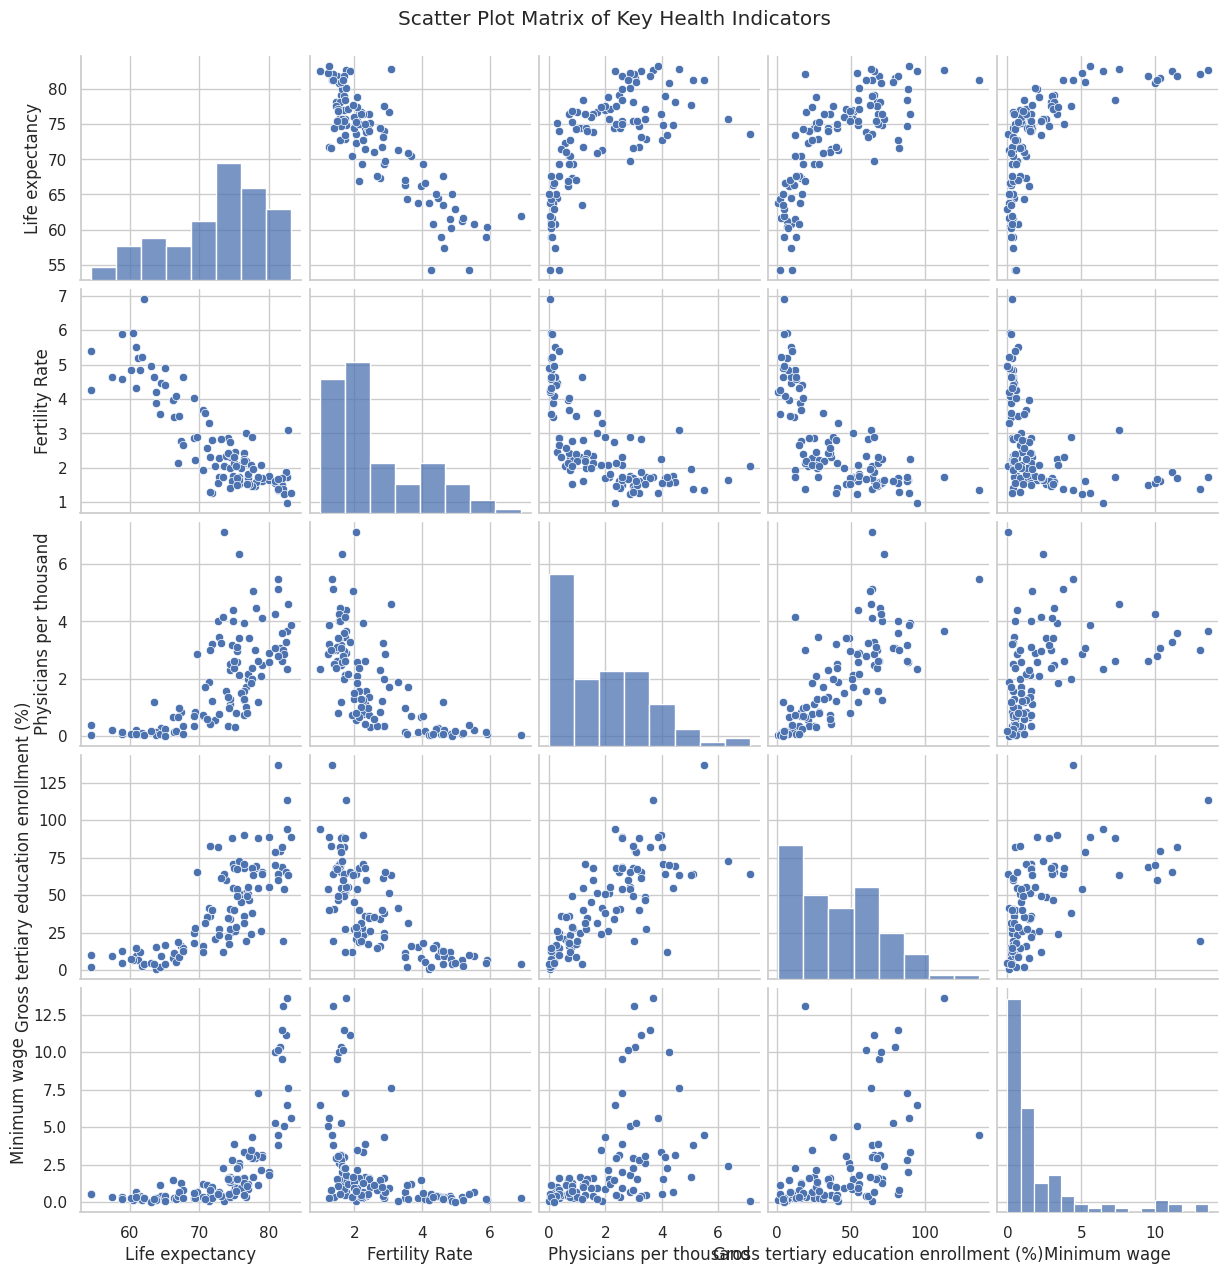

In [ ]:
health_indicators = df_plots[['Life expectancy', 'Fertility Rate','Physicians per thousand' ,'Gross tertiary education enrollment (%)','Minimum wage']]
sns.pairplot(health_indicators)
plt.suptitle('Scatter Plot Matrix of Key Health Indicators', y=1.02)
plt.show()

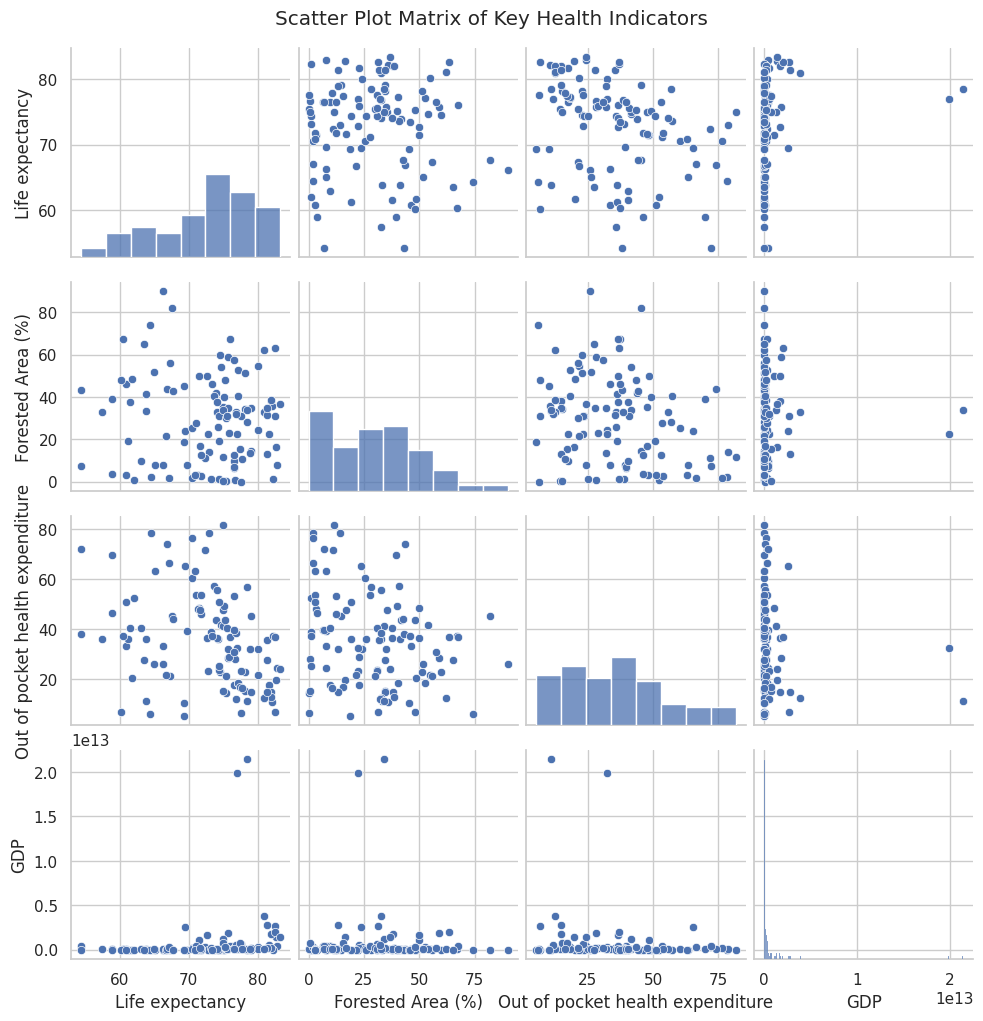

In [ ]:
health_indicators = df_plots[['Life expectancy', 'Forested Area (%)',
                        'Out of pocket health expenditure' ,'GDP']]
sns.pairplot(health_indicators)
plt.suptitle('Scatter Plot Matrix of Key Health Indicators', y=1.02)
plt.show()

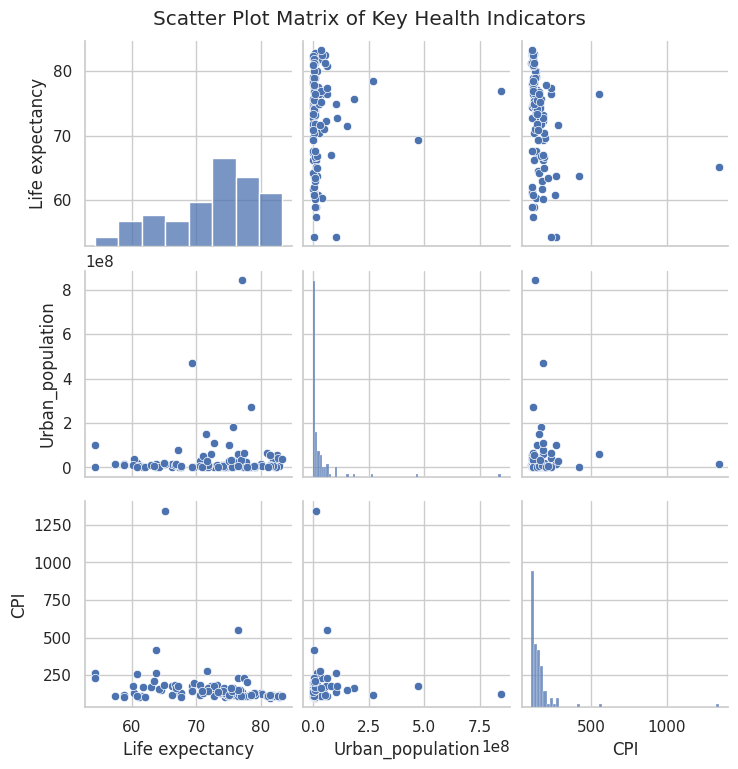

In [ ]:
health_indicators = df_plots[['Life expectancy','Urban_population','CPI']]
sns.pairplot(health_indicators)
plt.suptitle('Scatter Plot Matrix of Key Health Indicators', y=1.02)
plt.show()

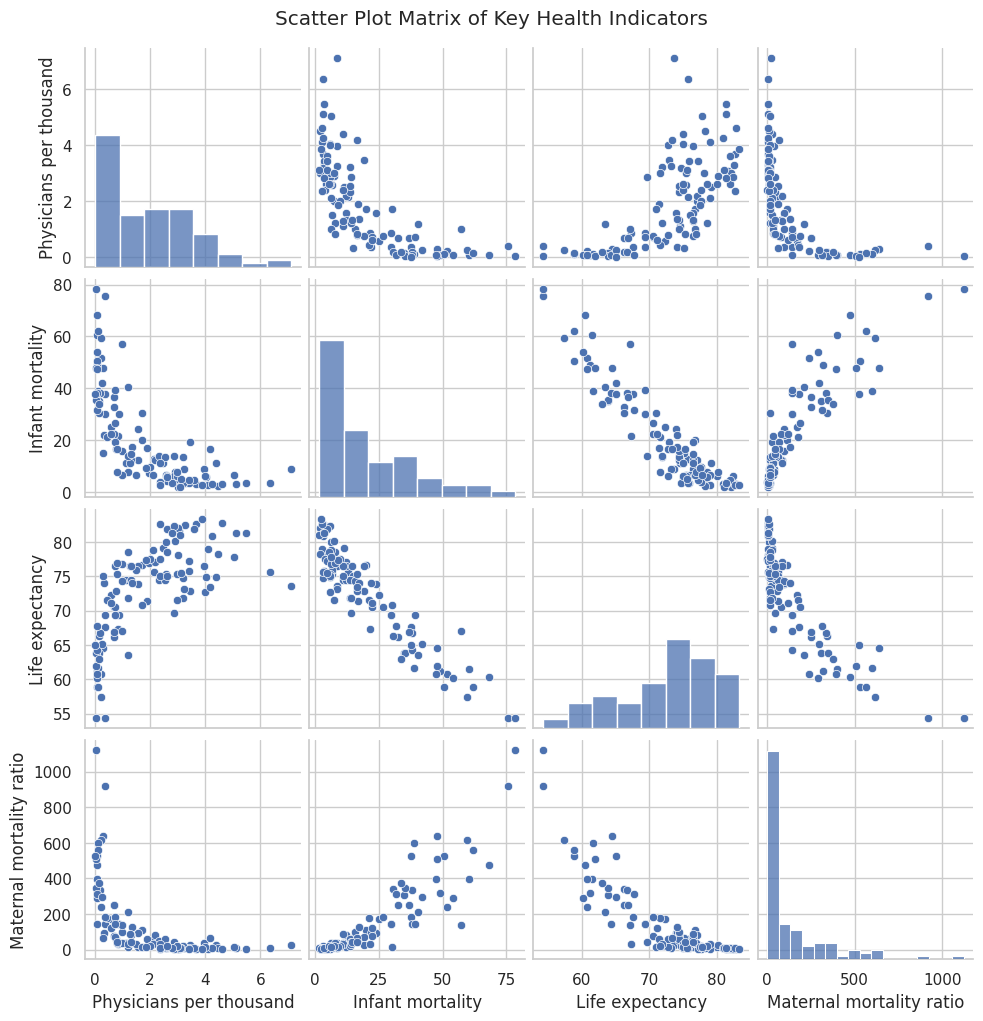

In [ ]:
health_indicators = df_plots[['Physicians per thousand', 'Infant mortality',
                        'Life expectancy','Maternal mortality ratio']]
sns.pairplot(health_indicators)
plt.suptitle('Scatter Plot Matrix of Key Health Indicators', y=1.02)
plt.show()

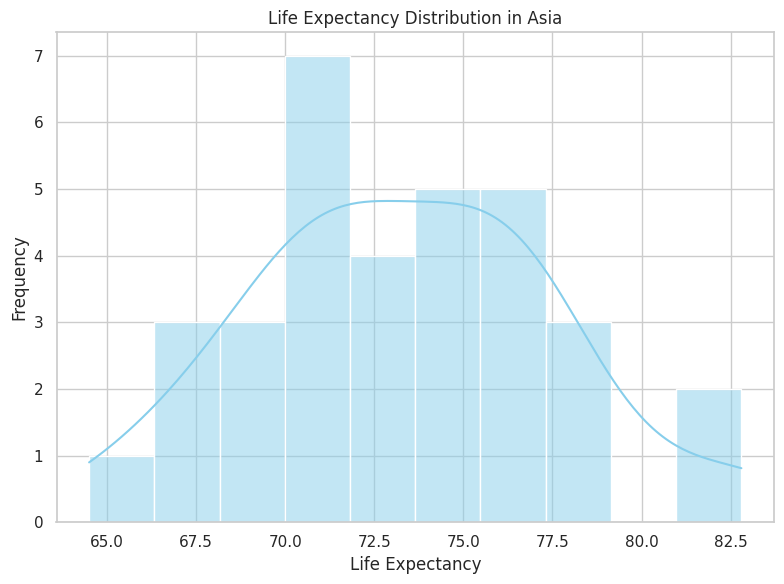

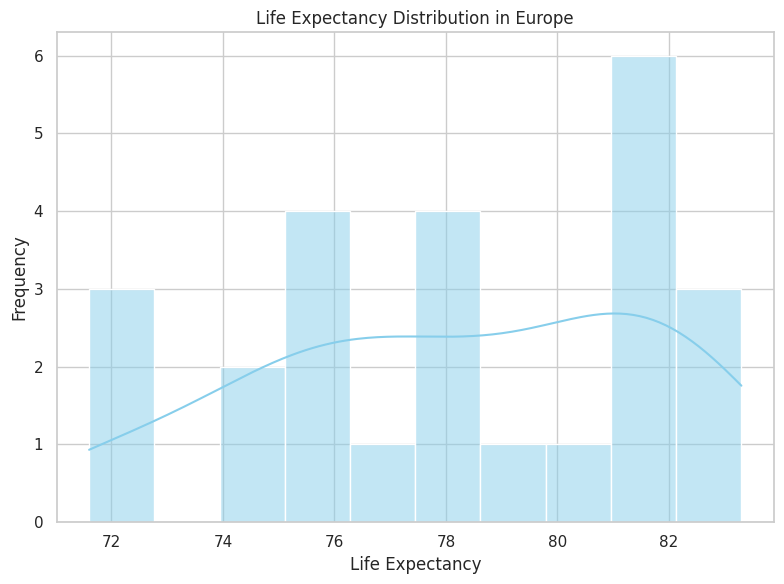

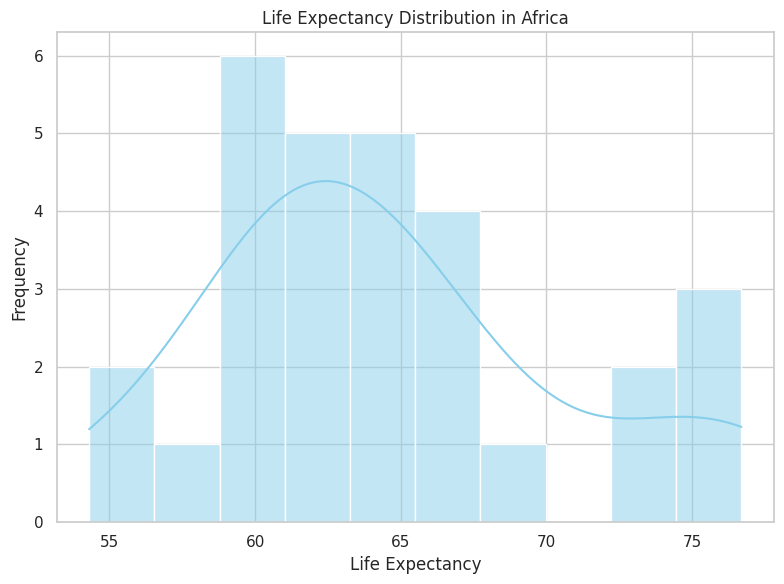

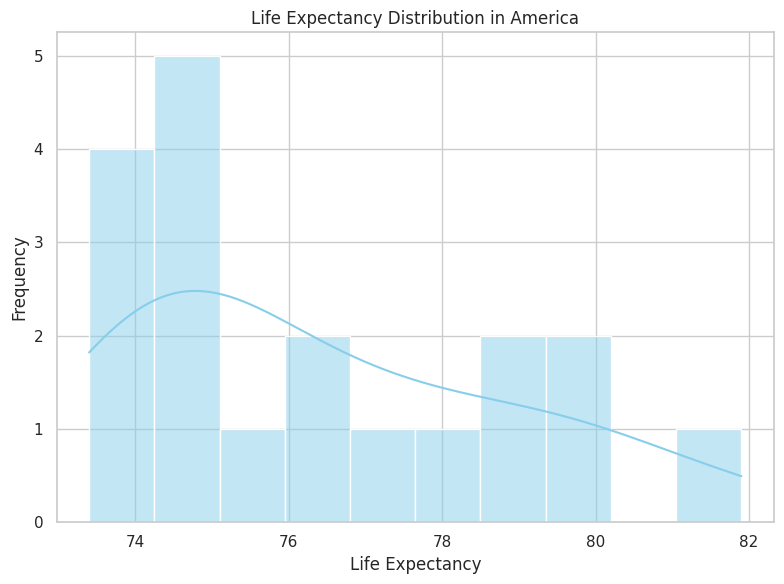

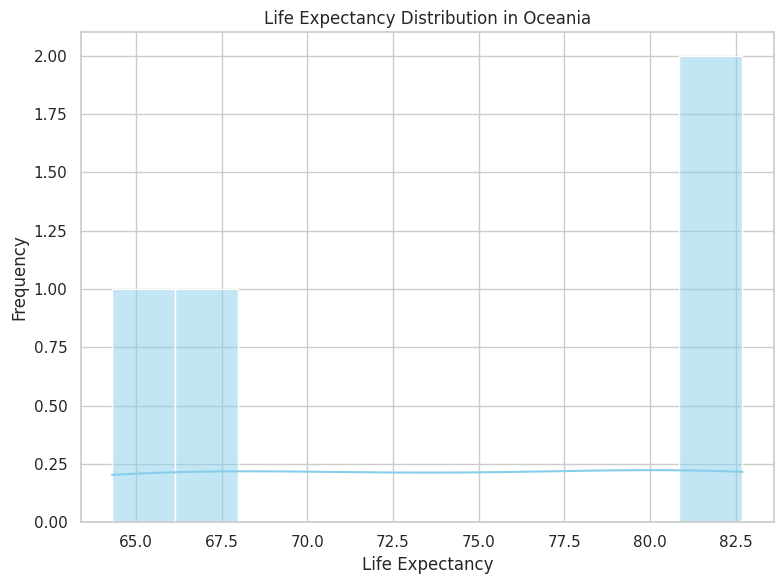

In [ ]:
continents = df_plots['Continent'].unique()
for continent in continents:
    plt.figure(figsize=(8, 6))
    continent_data = df_plots[df_plots['Continent'] == continent]
    sns.histplot(data=continent_data, x='Life expectancy', kde=True, color='skyblue', bins=10)
    plt.title(f'Life Expectancy Distribution in {continent}')
    plt.xlabel('Life Expectancy')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

### minimal adequate Model

In [ ]:
#Functions to get the minimal adequate model
def calculate_vif_Total(df, vif_threshold):
    droplist = ["LifeExpectancy", 'MinimumWage', 'GasolinePrice']
    all_vars_1 = "+".join(df.columns.drop(droplist))

    VIF = False
    while VIF == False:
        model = smf.ols("I(np.log(91-LifeExpectancy)) ~ " + all_vars_1, df).fit()
        X = model.model.exog
        vv = pd.Series([variance_inflation_factor(X, i) for i in range(X.shape[1])], index=model.params.index)
        vv_sort = vv.sort_values(ascending=False)
        # print(vv_sort)
        # print("\n\n")
        if vv_sort.index[0] == "Intercept":
            if vv_sort[1] > vif_threshold:
                # print(vv_sort.index[1])
                droplist.append(vv_sort.index[1])
                all_vars_1 = "+".join(df.columns.drop(droplist))
            else:
              VIF = True
        elif vv_sort[0] > vif_threshold:
            # print(vv_sort.index[0])
            droplist.append(vv_sort.index[0])
            all_vars_1 = "+".join(df.columns.drop(droplist))
        else:
            VIF = True

    return model,all_vars_1,droplist


def calculate_P_value(model, Pvalue,all_vars_1,droplist):

    VIF = False
    while VIF == False:
        model = smf.ols("I(np.log(91-LifeExpectancy)) ~ " + all_vars_1, df).fit()
        pvalue_sort=model.pvalues.sort_values(ascending=False)
        # print(pvalue_sort)
        # print("\n\n")
        if pvalue_sort.index[0] == "Intercept":
            if pvalue_sort[1] > Pvalue:
                # print(vv_sort.index[1])
                droplist.append(pvalue_sort.index[1])
                all_vars_1 = "+".join(df.columns.drop(droplist))
            else:
              VIF = True
        elif pvalue_sort[0] > Pvalue:
            # print(vv_sort.index[0])
            droplist.append(pvalue_sort.index[0])
            all_vars_1 = "+".join(df.columns.drop(droplist))
        else:
            VIF = True

    return model





# Example usage:
# Assuming df is your DataFrame
# Assuming vif_threshold is the threshold for VIF that you want to use
model,all_vars_1,droplist = calculate_vif_Total(df, 2)
Final_Model=calculate_P_value(model,0.05,all_vars_1,droplist)
print(Final_Model.summary())
# print(model.summary())
# print(p_values)
# print(p_values.index[0])
# calculate_P_value
# print("Variables to drop:", dropped_variables)


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_

                                  OLS Regression Results                                  
Dep. Variable:     I(np.log(91 - LifeExpectancy))   R-squared:                       0.735
Model:                                        OLS   Adj. R-squared:                  0.722
Method:                             Least Squares   F-statistic:                     57.60
Date:                            Sun, 10 Dec 2023   Prob (F-statistic):           2.02e-28
Time:                                    13:46:52   Log-Likelihood:                 22.797
No. Observations:                             110   AIC:                            -33.59
Df Residuals:                                 104   BIC:                            -17.39
Df Model:                                       5                                         
Covariance Type:                        nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      

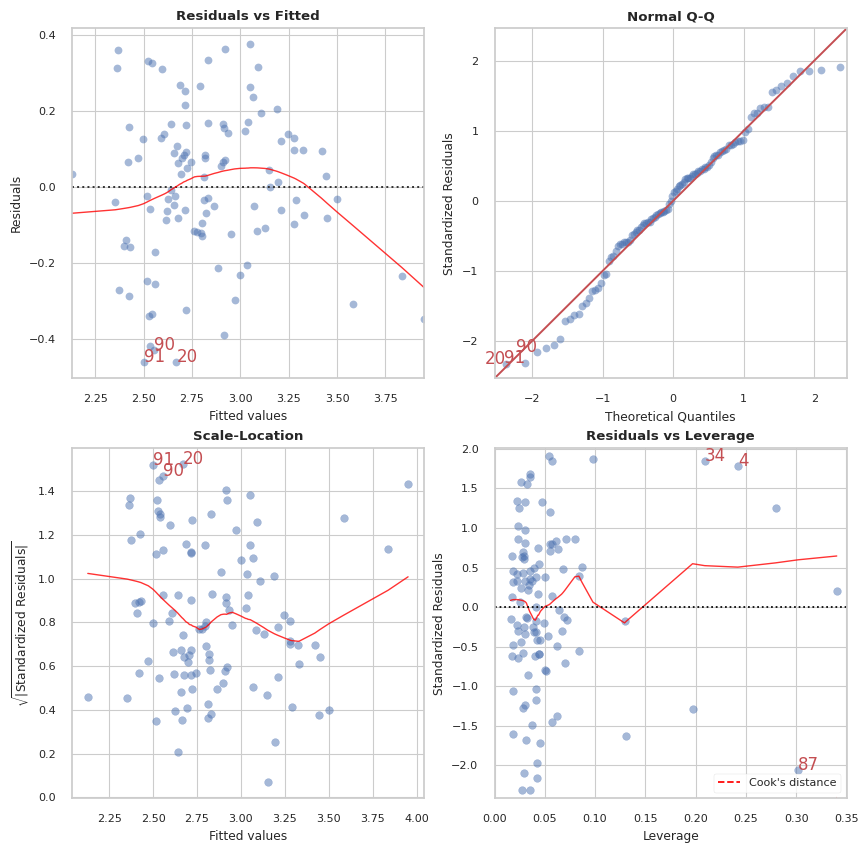

In [ ]:
cls_1 = LinearRegDiagnostic(Final_Model)
_, fig, ax = cls_1()

In [ ]:
print(f"P-value by Shapiro-Wilk test for residuals normality (Model 1): {np.round(stats.shapiro(Final_Model.resid)[1], 3)}")

P-value by Shapiro-Wilk test for residuals normality (Model 1): 0.109


In [ ]:
print(f"P-value by Breuschpagan test for residuals homoscedasticity (Model 1): {np.round(sm.stats.het_breuschpagan(Final_Model.resid, Final_Model.model.exog, False)[1], 3)}")

P-value by Breuschpagan test for residuals homoscedasticity (Model 1): 0.2


### BIC

In [ ]:
y =  np.log( 91 - df['LifeExpectancy'])
X = df.drop(["LifeExpectancy","MinimumWage","GasolinePrice"], axis = 1)
result_bic_recheck = stepwise_selection_bic_recheck(X, y)

Add InfantMortality                with BIC -46.4108
Add GrossTertiaryEducationEnrollment_Percentage with BIC -57.2761
Add Density_P_Km2                  with BIC -65.9768
Add OutOfPocketHealthExpenditure   with BIC -71.9194


In [ ]:
model_BIC = smf.ols("I(np.log(91-LifeExpectancy)) ~  InfantMortality + Density_P_Km2 + GrossTertiaryEducationEnrollment_Percentage + OutOfPocketHealthExpenditure", df).fit()
print(model_BIC.summary())

                                  OLS Regression Results                                  
Dep. Variable:     I(np.log(91 - LifeExpectancy))   R-squared:                       0.831
Model:                                        OLS   Adj. R-squared:                  0.825
Method:                             Least Squares   F-statistic:                     129.4
Date:                            Sun, 10 Dec 2023   Prob (F-statistic):           1.17e-39
Time:                                    13:46:54   Log-Likelihood:                 47.711
No. Observations:                             110   AIC:                            -85.42
Df Residuals:                                 105   BIC:                            -71.92
Df Model:                                       4                                         
Covariance Type:                        nonrobust                                         
                                                  coef    std err          t      P>|t|   

In [ ]:
def calculate_vif(model):
        X = model.model.exog
        return pd.Series([variance_inflation_factor(X, i) for i in range(X.shape[1])],
    index=model.params.index)
print("VIF for Model_BIC: ", round(calculate_vif(model_BIC).sort_values(ascending=False), 3))

VIF for Model_BIC:  Intercept                                      17.614
InfantMortality                                 2.557
GrossTertiaryEducationEnrollment_Percentage     2.351
OutOfPocketHealthExpenditure                    1.191
Density_P_Km2                                   1.094
dtype: float64


In [ ]:
model_BIC = smf.ols("I(np.log(91-LifeExpectancy)) ~  Density_P_Km2 + GrossTertiaryEducationEnrollment_Percentage + OutOfPocketHealthExpenditure", df).fit()
print(model_BIC.summary())

                                  OLS Regression Results                                  
Dep. Variable:     I(np.log(91 - LifeExpectancy))   R-squared:                       0.705
Model:                                        OLS   Adj. R-squared:                  0.697
Method:                             Least Squares   F-statistic:                     84.56
Date:                            Sun, 10 Dec 2023   Prob (F-statistic):           5.25e-28
Time:                                    13:46:54   Log-Likelihood:                 17.020
No. Observations:                             110   AIC:                            -26.04
Df Residuals:                                 106   BIC:                            -15.24
Df Model:                                       3                                         
Covariance Type:                        nonrobust                                         
                                                  coef    std err          t      P>|t|   

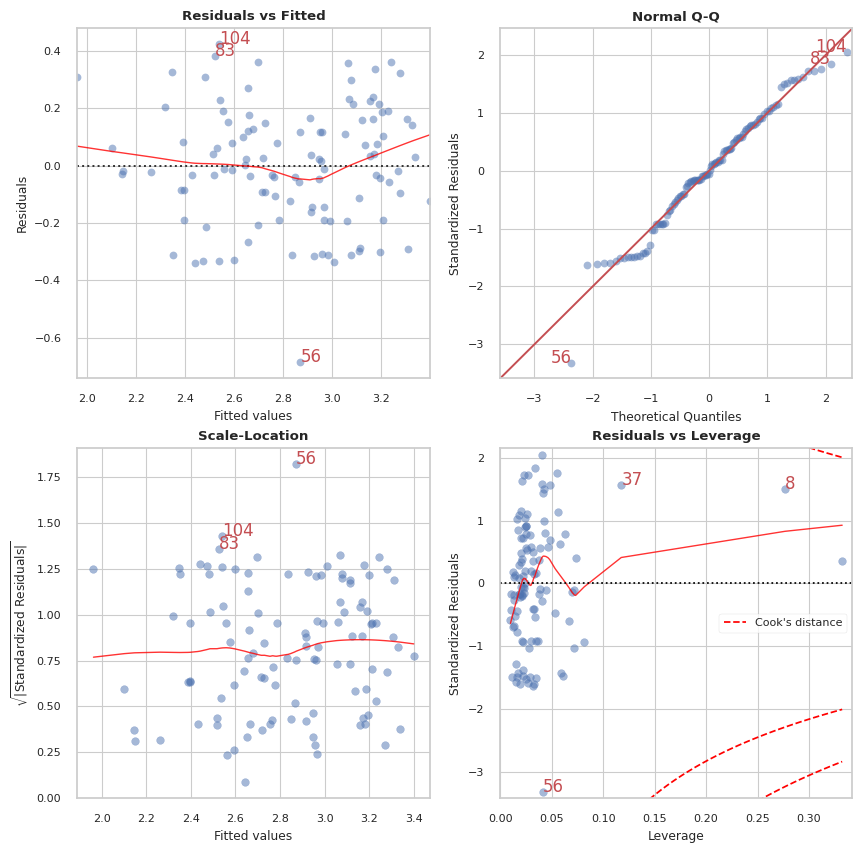

In [ ]:
cls_2 = LinearRegDiagnostic(model_BIC)
_, fig, ax = cls_2()

In [ ]:
print(f"P-value by Shapiro-Wilk test for residuals normality (Model 2): {np.round(stats.shapiro(model_BIC.resid)[1], 3)}")

P-value by Shapiro-Wilk test for residuals normality (Model 2): 0.07


In [ ]:
print(f"P-value by Breuschpagan test for residuals homoscedasticity (Model 2): {np.round(sm.stats.het_breuschpagan(model_BIC.resid, model_BIC.model.exog, False)[1], 3)}")

P-value by Breuschpagan test for residuals homoscedasticity (Model 2): 0.943


### Prediction

In [ ]:

##function to print the prediction for each Model
def prediction(selected_countries):
  All_Final_model_error=0
  All_BIC_error=0
  EDF_columns = ['Country', 'Actual', 'Predicted_Model','Predicted_BIC','Diffrence_Model','squareDiffrence_Model','Diffrence_BIC','squareDiffrence_BIC']
  EDF = pd.DataFrame(columns=EDF_columns)
  for _, item in selected_countries.iterrows():
    ##it will extract the columns for the specific model
    predict_model_10 = pd.DataFrame({'const': 1,'Density_P_Km2': [item['Density\n(P/Km2)']],
                                     'MaternalMortalityRatio': [item['Maternal mortality ratio']],
                                     'PhysiciansPerThousand': [item['Physicians per thousand']],
                                     'OutOfPocketHealthExpenditure': [item['Out of pocket health expenditure']],
                                     'TotalTaxRate': [item['Total tax rate']]},
                                     index = range(1))

    predict_10 = Final_Model.predict(predict_model_10)
    expected_10 = (-np.exp(predict_10))+91



    ##it will extract the columns for the specific model
    predict_model_BIC = pd.DataFrame({'const': 1,
                                      'GrossTertiaryEducationEnrollment_Percentage': [item['Gross tertiary education enrollment (%)']],
                                      'OutOfPocketHealthExpenditure': [item['Out of pocket health expenditure']],
                                      'Density_P_Km2': [item['Density\n(P/Km2)']]},
                                      index = range(1))
    predict_BIC = model_BIC.predict(predict_model_BIC)
    expected_BIC = (-np.exp(predict_BIC))+91

    final_model_error=(item['Life expectancy']-expected_10[0])
    BIC_error=(item['Life expectancy']-expected_BIC[0])

    All_Final_model_error+=(final_model_error)**2
    All_BIC_error+=(BIC_error)**2
    data = {
        'Country':item['Country'] ,
        'Actual': item['Life expectancy'],
        'Predicted_Model':round(expected_10[0],3) ,
        'Predicted_BIC':round(expected_BIC[0],3),
        'Diffrence_Model':round(final_model_error,3),
        'Diffrence_BIC':round(BIC_error,3),
        'squareDiffrence_Model':round((final_model_error**2),3),
        'squareDiffrence_BIC':round((BIC_error)**2,3)
    }
    EDF= EDF.append(data, ignore_index=True)
    print(f"Prediction for {item['Country']} using Model 1={round(expected_10[0],3)}\t\t using model_BIC 2 ={round(expected_BIC[0],3)} ")######## uncomment this to print the result
  # print(f"The Error for Final Model ={round(np.sqrt(All_Final_model_error),3)}\t\t The Error for BIC model={round(np.sqrt(All_BIC_error),3)}")## Not the correct way to calculate MSE
  print(f"The Error for Model 1 ={round((All_Final_model_error)/len(EDF),3)}\t\t The Error for BIC model 2={round((All_BIC_error)/len(EDF),3)}")## the correct way to calculate MSE

  return EDF

df2= pd.read_csv("world-data-2023.csv")
# Convert columns using a lambda function
df2[columns_to_convert] = df2[columns_to_convert].applymap(lambda x: float(str(x).replace(',', '').replace('$', '').replace('%', '')))

# Specify the countries you want to extract

selected_countries = ['Republic of Ireland',  'El Salvador', 'Republic of the Congo', 'Liberia', 'Japan', 'Netherlands', 'The Bahamas', 'Bhutan']

# Extract specific rows and columns based on conditions from all models
data_prediction = df2.loc[df2['Country'].isin(selected_countries), ['Country','Life expectancy', 'Maternal mortality ratio', 'Out of pocket health expenditure','Physicians per thousand','Total tax rate','Density\n(P/Km2)','Gross tertiary education enrollment (%)']]


EDF=prediction(data_prediction)### call the prediction function
EDF


Prediction for The Bahamas using Model 1=74.527		 using model_BIC 2 =68.78 
Prediction for Bhutan using Model 1=70.943		 using model_BIC 2 =69.566 
Prediction for Republic of the Congo using Model 1=64.868		 using model_BIC 2 =66.047 
Prediction for El Salvador using Model 1=76.251		 using model_BIC 2 =74.091 
Prediction for Republic of Ireland using Model 1=77.855		 using model_BIC 2 =79.716 
Prediction for Japan using Model 1=79.172		 using model_BIC 2 =79.826 
Prediction for Liberia using Model 1=60.363		 using model_BIC 2 =69.185 
Prediction for Netherlands using Model 1=80.874		 using model_BIC 2 =82.659 
The Error for Model 1 =8.515		 The Error for BIC model 2=11.201


<ipython-input-149-7e9c8a22b370>:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EDF= EDF.append(data, ignore_index=True)
<ipython-input-149-7e9c8a22b370>:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EDF= EDF.append(data, ignore_index=True)
<ipython-input-149-7e9c8a22b370>:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EDF= EDF.append(data, ignore_index=True)
<ipython-input-149-7e9c8a22b370>:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EDF= EDF.append(data, ignore_index=True)
<ipython-input-149-7e9c8a22b370>:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

,Country,Actual,Predicted_Model,Predicted_BIC,Diffrence_Model,squareDiffrence_Model,Diffrence_BIC,squareDiffrence_BIC
0,The Bahamas,73.8,74.527,68.780,-0.727,0.528,5.020,25.201
1,Bhutan,71.5,70.943,69.566,0.557,0.310,1.934,3.740
2,Republic of the Congo,64.3,64.868,66.047,-0.568,0.323,-1.747,3.051
3,El Salvador,73.1,76.251,74.091,-3.151,9.927,-0.991,0.983
4,Republic of Ireland,82.3,77.855,79.716,4.445,19.759,2.584,6.679
5,Japan,84.2,79.172,79.826,5.028,25.277,4.374,19.130
6,Liberia,63.7,60.363,69.185,3.337,11.135,-5.485,30.087
7,Netherlands,81.8,80.874,82.659,0.926,0.858,-0.859,0.738


In [ ]:
#Other Way to calcualte MSE
m1=np.array(EDF['Actual'])
m2=np.array(EDF['Predicted_Model'])
m3=np.array(EDF['Predicted_BIC'])
print(f"Model minimal adequate (Model 1) {mean_squared_error(m1,m2)}")
print(f"Model BIC(Model 2) {mean_squared_error(m1,m3)}")

Model minimal adequate (Model 1) 8.515257125000012
Model BIC(Model 2) 11.200860500000008
